# Investment and Trading Project

## Stock Predicton Project Definition

In [6]:
## HELPER FUNCTIONS
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import numpy as np
import math
import matplotlib.pyplot as plt
import datetime

# The stock we are interested in
stock_name = "QCOM"
# Data set includes stock prices beginning at start_date
stock_start_date = '2006-01-01'
# Number of historical days (M) to use for the prediction
# In baseline model, this is used to generate the prediction
# In lstm, this is an input sequence
M_historical_days = 30
# Predict for N days ahead
N_predict_days = 14
# Splits to use for TimeSeriesSplit
timeSeriesSplitCount = 4
# random_seed initial value
random_seed = 515

np.random.seed(random_seed)

def rmse_score(predicted, true_label):
    return math.sqrt(mean_squared_error(true_label, predicted))

In [9]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler

def prepareBaselineModelData(stock_data, m_days, n_days):
    """Prepares a data frame with input columns and prediction(y)
    for the baseline model using a dataframe that contains Adj. Close
    df - data frame provided to the model
    m_days - m historical days to use for prediction
    n_day - predict for n days ahead (not used)
    The created dataframe is the input provided to the model
    Each training sample's input is labelled c1, c2 upto c(m_days-1)
    This is the closing price for that day
    The true closing price for the problem is labelled y
    """

    df = pd.DataFrame()
    for i in range(m_days):
        closeCol = 'c' + str(i);
        df[closeCol] = stock_data.iloc[:]['Adj. Close'].shift(-i)
    df['y'] = stock_data.iloc[:]['Adj. Close'].shift(-m_days) # predicting for next day
    df = df.dropna()
    return df

def predictBaselineModel(df, m_days, useAverage):
    """Predict the value for the appropriate baseline model
    df - data frame provided to the model
    m_days - m historical days to use for prediction
    if useAverage is False, the predicted value is
    the c value for the previous day
    if useAverage is True, the predicted value is the
    mean of all the c values for that instance
    """

    # predict close as of last known or the mean of n_days
    result = df.drop(['y'], axis=1)
    if (useAverage is True):
        c_cols = []
        for i in range(m_days):
            c_cols.append('c' + str(i))
        result['y'] = df[c_cols].mean(axis=1)
    else:
        col = 'c' + str(m_days-1) # predict last known value
        result['y'] = df[:][col]        
    return result
    
def validateBaselineModel(ax, df, m_days, splits, dates, title, useAverage = True):
    """Predict the value for the appropriate baseline model
    m_days - m historical days to use for prediction
    splits - number of splits to use for TimeSeriesSplit
    dates - training and test dates. Used in graph plot
    if useAverage is False, the predicted value is
    the c value for the previous day
    if useAverage is True, the predicted value is the
    mean of all the c values for that instance
    """

    tsSplit = TimeSeriesSplit(n_splits=splits)
    baseline_scores = []
    for train_index, test_index in tsSplit.split(df):
        # create a min max scaler and scale the test set
        testScaler = MinMaxScaler(feature_range=(-1, 1))
        train, test = df.iloc[train_index], df.iloc[test_index]
        test_scaled = testScaler.fit_transform(test[df.columns])
        test_scaled = pd.DataFrame(test_scaled, columns=df.columns)
        test_dates = dates[len(train_index):len(train_index)+len(test_index)]

        actual = test_scaled
        predicted = predictBaselineModel(test_scaled, m_days, useAverage)
        y_pred = testScaler.inverse_transform(predicted)
        y_pred_df = pd.DataFrame(y_pred, columns=predicted.columns)
        y = testScaler.inverse_transform(actual)
        y_df = pd.DataFrame(y, columns=actual.columns)

        # score using rmse metric
        baseline_scores.append(rmse_score(y_pred_df['y'], y_df['y']))
        if (len(baseline_scores) == splits):
            cs.plot_graph(ax, test_dates, y_pred_df['y'], y_df['y'], title)

    return baseline_scores


def run_baseline(stock_data, split_count, M_history, N_predict):
    plt.close('all')
    num_baseline_types = 2
    fig, ax = plt.subplots(1, num_baseline_types, figsize=(14,8))
    temp_data = stock_data
    # preprocess data to shape suited for model
    stock_frame = prepareBaselineModelData(temp_data, M_history, N_predict)
    stock_dates = stock_frame.index.values
    stock_frame = stock_frame.reset_index().drop(['Date'], axis=1)
    #print(stock_dates.shape)
    #print(stock_frame.shape)
    title1 = "Baseline model - Same day prediction"
    title2 = "Baseline model - SMA over {} days prediction".format(M_history)
    # run baseline model for single day prediction using previous day's value
    score1 = validateBaselineModel(ax[0], stock_frame, M_history, split_count, \
                                   stock_dates, title1, False)
    # run baseline model for single day prediction using SMA of m historical days
    score2 = validateBaselineModel(ax[1], stock_frame, M_history, split_count, \
                                   stock_dates, title2, True)
    print("{} score : mean - {}".format(title1, np.mean(score1)))
    print("{} score : mean - {}".format(title2, np.mean(score2)))
    plt.show()


Test dates start 2015-08-26 end 2018-01-25
Test dates start 2015-08-26 end 2018-01-25
Baseline model - Same day prediction score : mean - 0.8824490229557594
Baseline model - SMA over 30 days prediction score : mean - 2.506997629710077


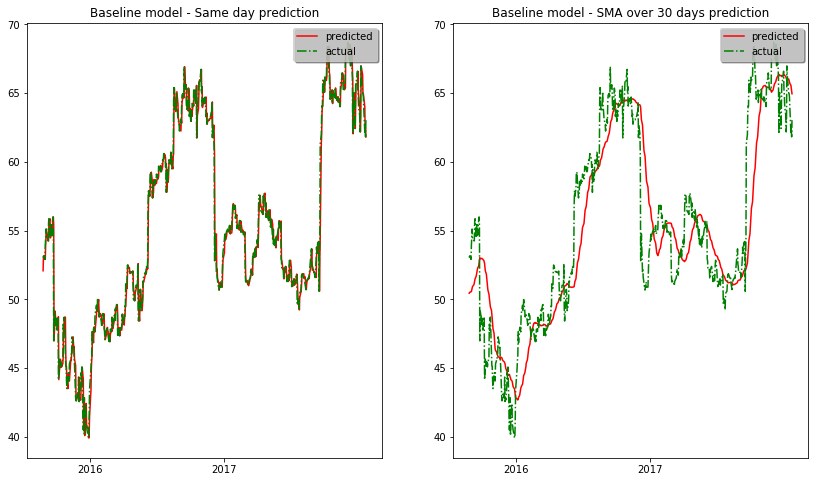

In [8]:
# get the stock dataframe and drop all column except Adj. Close
stockdf = cs.get_stock_dataframe(stock_name, dateFrom = stock_start_date)
stockdf = stockdf[['Adj. Close']]
run_baseline(stockdf, timeSeriesSplitCount, M_historical_days, N_predict_days)
# [2.60424767263038, 3.696717167358234] when y is considered with N_predict_days
# [1.3040513563033131, 1.8361952433433824] why y assumes next day prediction

In [10]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import numpy as np
import matplotlib.pyplot as plt
from keras import backend

# set a random seed to get consistent results across runs
np.random.seed(random_seed)
def rmse_metric(y, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_pred - y), axis=-1))

def prepareLSTMModelData(stockdf, timesteps):
    """Transform stock data frame to a shape appropriate for 
    LSTM model. 3D shape of (num_samples, timesteps, num_features)
    timesteps - size of the input sequence for each sample
    """

    num_samples = stockdf.shape[0] - (timesteps)
    num_features = stockdf.shape[1]
    print(stockdf.shape)
    X = np.zeros((num_samples, timesteps, num_features))
    y = np.zeros((num_samples))
    
    for i in range(num_samples):
        y_pos = i + timesteps
        X[i] = stockdf[i:y_pos]
        y[i] = stockdf['Adj. Close'][y_pos]

    return (X, y)

def prepareMultiVariateLSTMModelData(stockdf, timesteps):
    return prepareLSTMModelData(stockdf, timesteps)

def createLSTMModel(X_train, m_days, n_days, \
        neurons, num_epochs, mBatches, mStateFul, lossFn, modelOptimizer, use_metric=False):
    """Create the sequential stacked LSTM model
    X_train - training dataframe - used to assign input_shape
    m_days - m historical days to use
    n_days - predict n days ahead
    neurons - number of cells for the LSTM model
    num_epochs - number of epochs to train
    mBatches - batch_size to set for training. Consider size based on stateful
    mStateFul - true to use a stateful LSTM model
    lossFn - the loss function to use
    modelOptimizer - the optimizer to use
    useMetric - set to true when running model evaluation
    """

    model = Sequential()
    if (mStateFul == True):
        model.add(LSTM(neurons, input_shape=(X_train.shape[1], X_train.shape[2]),\
                return_sequences=True, \
                stateful=True, batch_size=mBatches))
    else:
        model.add(LSTM(neurons, input_shape=(X_train.shape[1], X_train.shape[2]),\
                   return_sequences=True))
    #model.add(LSTM(20, return_sequences=True))
    model.add(LSTM(neurons))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    if (use_metric == True):
        model.compile(loss=lossFn, optimizer=modelOptimizer, metrics=[rmse_metric])
    else:
        model.compile(loss=rmse_metric, optimizer=modelOptimizer)
    #print(model.summary())
    return model

def appendWithPrediction(lstm_input, prediction, m_days):
    """Use prediction as input sequence for next day prediction
    LSTM models built predict for only one day ahead. To simulate
    multi day prediction, we slide sequences in each input sample
    to accomodate the predicted value as the input for subsequent
    day's prediction
    lstm_input - original lstm input
    prediction - value predicted and now to be used as input
    m_days - historical m days to use - is the timesteps
    """

    for i in range(1, m_days):
        lstm_input[:, i-1, :] = lstm_input[:, i, :]
    lstm_input[:, m_days-1, :] = prediction
    return lstm_input

def score_prediction(model, scaler_test, X_test, y_test, m_days, n_days):
    """Evaluate the model performane
    model - model that is used for prediction
    scaler_test - MinMaxScaler to use to scale the prediction
    X_test - input test set
    y_test - actual test labels
    m_days - historical m days to use.
    n_days - predict n days ahead. Run model prediction for n_days
    while sliding the input for the prediction using predicted value
    Returns the score, the re-scaled predicted and actual values
    """

    #print("X test {} and Y test {}".format(X_test.shape, y_test.shape))
    predicted = None
    for i in range(n_days):
        # predict for next day
        predicted = model.predict(X_test, batch_size=1)
        # create new X_test by appending predicted value to timestep
        # and pop out oldest value in timestep sequence
        X_test = appendWithPrediction(X_test, predicted, m_days)
        #print("Iter {} : new X test {}".format(i, X_test.shape))

    y_test = y_test.reshape(-1,1)
    #print("Reshaped predicted {} and y_test {}".format(predicted.shape, y_test.shape))

    # inverse scale the prediction to actual closing-prices
    y_pred = scaler_test.inverse_transform(predicted)
    y_pred = y_pred[n_days:]
    y_pred_df = pd.DataFrame(y_pred, columns=["y_pred"])
    y_actual = scaler_test.inverse_transform(y_test)
    y_actual = y_actual[n_days:]
    y_actual_df = pd.DataFrame(y_actual, columns=["y"])

    # evaluate prediction against true value
    score = rmse_score(y_pred_df['y_pred'], y_actual_df['y'])
    print(score)
    return score, y_pred, y_actual;

Using TensorFlow backend.


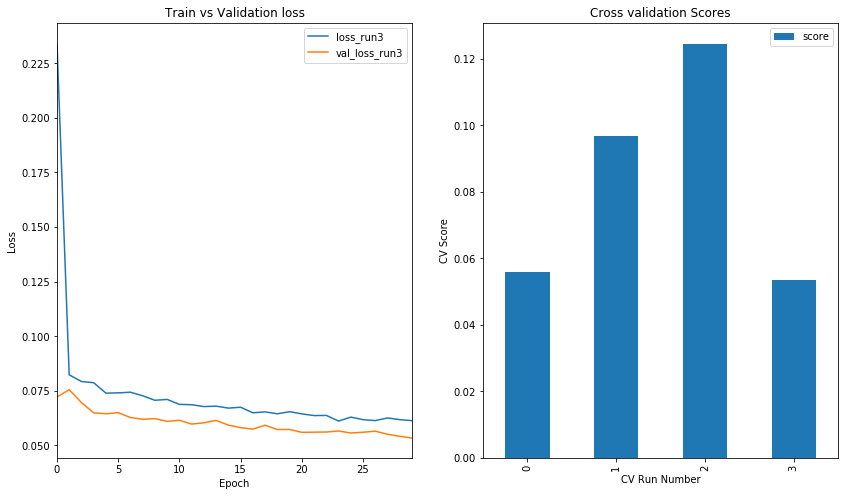

In [17]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import Callback
import numpy as np
import matplotlib.pyplot as plt
from keras import backend
from sklearn.model_selection import TimeSeriesSplit
import os

class ModelHistory(Callback):
    """Model history object passed as callback to model.fit()
    For stateful models, even though we reset the states
    we still need a way to record the metric and loss across
    epochs. Use this callback to record events on different stages
    of model training
    """
    def __init__(self):
        self.train_losses = []
        self.val_losses = []
        
    def on_batch_end(self, batch, logs={}):
        pass

    def on_epoch_end(self, batch, logs={}):
        self.train_losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

def plot_train_validation(ax, train_stat, val_stat, title, y_label):
    """Plot learning curves for training and validation loss
    over multiple training epochs
    train_stat - training losses as a list
    val_stat - validation losses as a list
    title - title of the plot
    y_label - y label to use for the plot
    """    
    ax.plot(train_stat)
    ax.plot(val_stat)
    ax.set_title(title)
    ax.set_ylabel(y_label)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'validation'], loc='upper right')

def plot_all_train_validation(axPlot, frame, title):
    """Plot learning curves for training and validation loss
    over multiple training epochs for all the TrainTestSplits
    frame - data frame the contains all the training and
    validation losses for multiple runs
    """    
    axPlot.set_title(title)
    axPlot.set_ylabel('Loss')
    axPlot.set_xlabel('Epoch')
    frame.plot(ax=axPlot)

def evaluateLSTMModel(scorePrediction, df, m_days, n_days, splits, dates, \
                      neurons=20, num_epochs=1, mBatches=1, mStateFul=False, lossFn='mae', modelOptimizer='sgd'):
    """Evaluate the LSTM model for the parameters chosen
    by training a model and validating it on a validation set
    Final evaluation score is based on the aggregation of multiple
    training & validation runs
    scorePrediction - evaluate based on a test set prediction
    """    

    # Create the MinMax scalers for both train and test sets
    scaler_train = MinMaxScaler(feature_range=(-1, 1))
    scaler_test = MinMaxScaler(feature_range=(-1, 1))
    df = df.reset_index().drop(['Date'], axis=1)
    split = 0.8
    # use all the data if we are evalating on validation set
    if (scorePrediction == False):
        split = 1
    train_test_split = int(df.shape[0] * split)
    # create the test train splits
    train, test = df[0:train_test_split], df[train_test_split:]
    print("Train {} and test {}".format(train.shape, test.shape))
    # scale the inputs based on the MinMax scaler
    train_scaled = scaler_train.fit_transform(train[df.columns])
    train_scaled = pd.DataFrame(train_scaled, columns=df.columns)
    test_scaled = None
    test_dates = None
    X_test, y_test = None, None
    if (scorePrediction == True):
        test_scaled = scaler_test.fit_transform(test[df.columns])
        test_scaled = pd.DataFrame(test_scaled, columns=df.columns)
        test_dates = dates[train_test_split+m_days:]
        X_test, y_test = prepareLSTMModelData(test_scaled, m_days)

    model_history_list = []
    score_list = []
    # use TimeSeries split to get indexes to use for training vs validation
    tsSplit = TimeSeriesSplit(n_splits=splits)
    for train_index, validation_index in tsSplit.split(train_scaled):
        trainSet, validationSet = train_scaled.loc[train_index], train_scaled.loc[validation_index]
        # validation set is indexed from a non-zero value. Reset index and drop newly
        # created index so that validation set is also indexed from zero
        validationSet.reset_index(inplace=True, drop=True)
        # preprocess train/test set for LSTM input
        X_train, y_train = prepareLSTMModelData(trainSet, m_days)
        X_val, y_val =  prepareLSTMModelData(validationSet, m_days)
        model = createLSTMModel(X_train, m_days, n_days,\
                    neurons, num_epochs, mBatches, mStateFul, lossFn, modelOptimizer, True)
        history = None
        model_history = ModelHistory();
        # fit the model over multiple epochs. Reset state between epochs
        for i in range(num_epochs):
            history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                  epochs=1, batch_size=mBatches, callbacks=[model_history])
            model.reset_states()
        model_history_list += [model_history]
        if (scorePrediction == True):
            score, u, v = score_prediction(model, scaler_test, X_test, y_test, m_days, n_days)
            score_list += [score]
        else:
            loss, metric = model.evaluate(X_val, y_val, batch_size=mBatches)
            score_list += [metric]

    last_history = model_history_list[len(model_history_list)-1]
    plt.close('all')

    # plot the training and validation loss for the last run
    fig, ax = plt.subplots(1, 1, figsize=(14,8))
    plot_train_validation(ax, last_history.train_losses, last_history.val_losses, "Train vs Validation loss", 'loss')
    plt.show()

    print(score_list)
    return score_list, model_history_list

def doModelEvaluation():
    stockdf = cs.get_stock_dataframe(stock_name, dateFrom = stock_start_date)
    stock_data = stockdf[['Adj. Close']]
    stock_frame = stock_data
    stock_dates = stock_frame.index.values
    return evaluateLSTMModel(False, stock_frame, 30, 1, timeSeriesSplitCount, stock_dates, 30, 30, 30, False)
    #return evaluateLSTMModel(False, stock_frame, 30, 1, 2, stock_dates, 2, 2, 15, False)
    #print("Mean = {} and best = {}".format(np.mean(score), score[len(score)-1]))

# if the evaluation history is already saved off as csv files
# use the history instead of re-running the time consuming model evaluation
evaluation_history = "capstone_evaluation_history.csv"
evaluation_scores = "capstone_evaluation_scores.csv"
if os.path.exists(evaluation_history) == False or os.path.exists(evaluation_scores) == False:
    eval_score, eval_history = doModelEvaluation()
    eval_score_df = pd.DataFrame(eval_score, columns=['score'])
    eval_history_df = pd.DataFrame()
    for index, history in enumerate(eval_history):
        eval_history_df['loss_run'+str(index)] = history.train_losses
        eval_history_df['val_loss_run'+str(index)] = history.val_losses
    eval_score_df.to_csv(evaluation_scores)
    eval_history_df.to_csv(evaluation_history)

# plot training and validation loss curves for all the runs
# plot the scores for each run
eval_score_df = pd.read_csv(evaluation_scores)
eval_history_df = pd.read_csv(evaluation_history)
plt.close('all')
fig, ax = plt.subplots(1, 2, figsize=(14,8))
eval_history_df.drop(['Unnamed: 0'], axis=1, inplace=True)
eval_score_df.drop(['Unnamed: 0'], axis=1, inplace=True)
plot_all_train_validation(ax[0], eval_history_df[['loss_run3', 'val_loss_run3']], "Train vs Validation loss")
eval_score_df.plot(ax=ax[1], kind='bar', title='Cross validation Scores')
ax[1].set(xlabel="CV Run Number", ylabel="CV Score")
plt.show()

Train (2145, 1) and test (920, 1)
(2145, 1)
X train (2131, 14, 1) and Y train (2131,)
Test dates (906,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 14, 30)            3840      
_________________________________________________________________
lstm_2 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
Total params: 11,191.0
Trainable params: 11,191.0
Non-trainable params: 0.0
_________________________________________________________________
None
Epoch 1/1
2131/2131 [==============================] - 3s - loss: 0.2862       

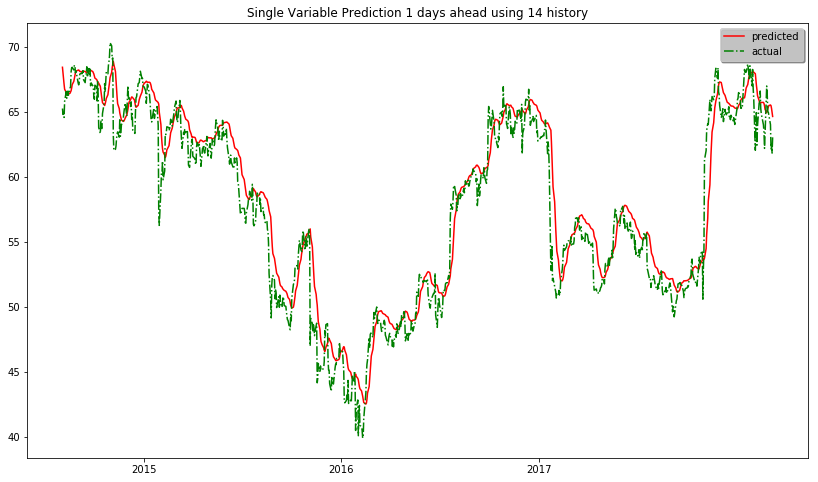

Train (2145, 1) and test (920, 1)
(2145, 1)
X train (2115, 30, 1) and Y train (2115,)
Test dates (890,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 30, 30)            3840      
_________________________________________________________________
lstm_4 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 31        
Total params: 11,191.0
Trainable params: 11,191.0
Non-trainable params: 0.0
_________________________________________________________________
None
Epoch 1/1
2115/2115 [==============================] - 5s - loss: 0.3616       

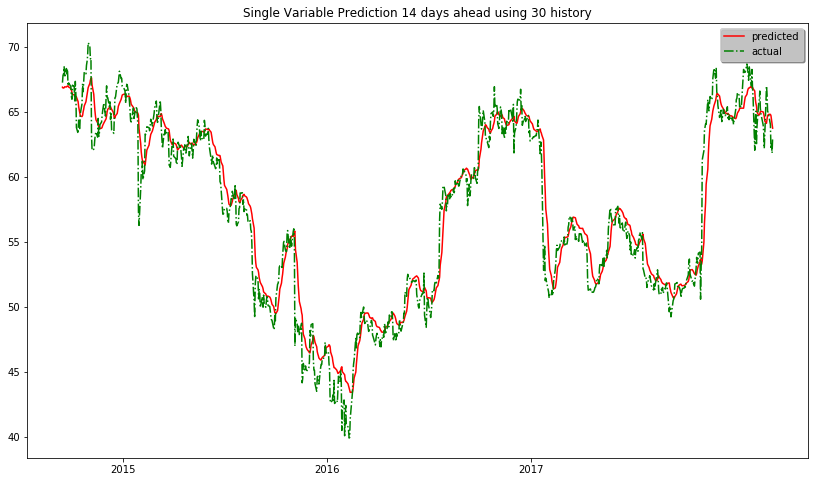

Train (2145, 1) and test (920, 1)
(2145, 1)
X train (2085, 60, 1) and Y train (2085,)
Test dates (860,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 60, 30)            3840      
_________________________________________________________________
lstm_6 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dropout_3 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 31        
Total params: 11,191.0
Trainable params: 11,191.0
Non-trainable params: 0.0
_________________________________________________________________
None
Epoch 1/1
2085/2085 [==============================] - 9s - loss: 0.2500       

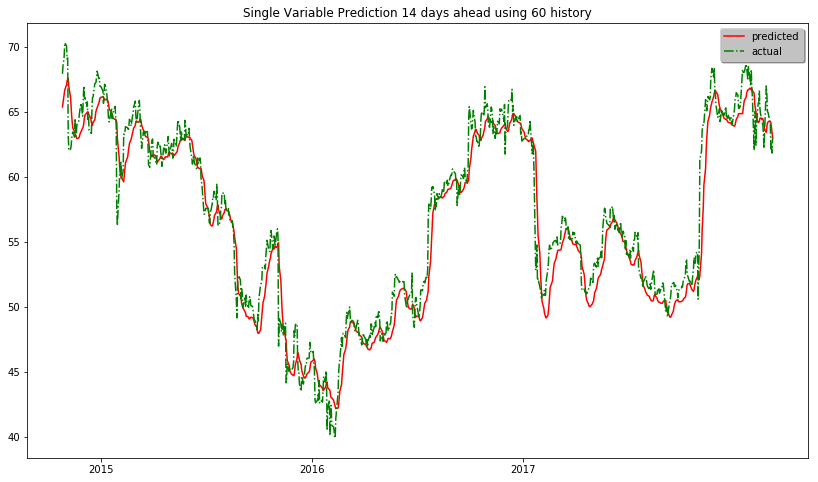

Model2 Scores: 2.022714619125958 1.719829179256257 1.7212851423760063


In [13]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import numpy as np
import matplotlib.pyplot as plt
from keras import backend

np.random.seed(random_seed)

def predictOnLSTMModel(ax, df, m_days, n_days, splits, dates, \
                      neurons=20, num_epochs=1, mBatches=1, mStateFul=False, lossFn='mae', modelOptimizer='sgd'):
    """Do prediction on the LSTM model trained on a single varaible
    Evaluate the model using the prediction and plot
    the prediction vs actual values
    """    

    # create the min max scalers for train and test set
    scaler_train = MinMaxScaler(feature_range=(-1, 1))
    scaler_test = MinMaxScaler(feature_range=(-1, 1))
    train_test_split = int(df.shape[0] * 0.7)
    df = df.reset_index().drop(['Date'], axis=1)
    # create the train and test data sets
    train, test = df[0:train_test_split], df[train_test_split:]
    print("Train {} and test {}".format(train.shape, test.shape))
    # scale inputs to min-max range
    train_scaled = scaler_train.fit_transform(train[df.columns])
    train_scaled = pd.DataFrame(train_scaled, columns=df.columns)
    test_scaled = scaler_test.fit_transform(test[df.columns])
    test_scaled = pd.DataFrame(test_scaled, columns=df.columns)

    # prepare the training data set for an LSTM input
    X_train, y_train = prepareLSTMModelData(train_scaled, m_days)
    test_dates = dates[train_test_split+m_days:]

    print("X train {} and Y train {}".format(X_train.shape, y_train.shape))
    print("Test dates {}".format(test_dates.shape))
    model = createLSTMModel(X_train, m_days, n_days, neurons, num_epochs, mBatches, mStateFul, lossFn, modelOptimizer)
    history = None
    for i in range(num_epochs):
        history = model.fit(X_train, y_train,
              epochs=1, batch_size=mBatches)
        model.reset_states()
    # prepare test data set for LSTM input
    X_test, y_test = prepareLSTMModelData(test_scaled, m_days)
    # score the prediction to the actual values
    score, y_pred, y_actual = score_prediction(model, scaler_test, X_test, y_test, m_days, n_days)
    # drop dates that are not relevant for plotting
    test_dates = test_dates[n_days:]
    print("test_dates shape {} vs y_pred shape {} vs y_test shape {}" \
          .format(test_dates.shape, y_pred.shape, y_test.shape))

    # plot the prediction against the actual value
    if ax is not None:
        plotTitle = "Single Variable Prediction {} days ahead using {} history".format(n_days, m_days)
        cs.plot_graph(ax, test_dates, y_pred, y_actual, plotTitle)

    print(score)
    return score

def doPrediction(stock_data, split_count, M_history, N_predict, useStateFul):
    plt.close('all')
    fig, ax = plt.subplots(1, 1, figsize=(14,8))
    stock_frame = stock_data
    stock_dates = stock_frame.index.values
    score = 0
    # a convenience variable to allow running both stateful and stateless models
    if (useStateFul == False):
        score = predictOnLSTMModel(ax, stock_frame, M_history, N_predict, split_count, stock_dates, 30, 30, 30, False)
    else:
        score = predictOnLSTMModel(ax, stock_frame, M_history, N_predict, split_count, stock_dates, 30, 30, 1, True)
    plt.show()
    return score


stockdf = cs.get_stock_dataframe(stock_name, dateFrom = stock_start_date)
stockdf = stockdf[['Adj. Close']]
model2_score_14_1 = doPrediction(stockdf, timeSeriesSplitCount, 14, 1, False)
model2_score_30_14 = doPrediction(stockdf, timeSeriesSplitCount, 30, 14, False)
model2_score_60_14 = doPrediction(stockdf, timeSeriesSplitCount, 60, 14, False)
print("Model2 Scores: {} {} {}".format(model2_score_14_1, model2_score_30_14, model2_score_60_14))
# hist, prediction = (14,1), (30,14), (60,14)
# 30 Neuron 10 epoch stateful=False batchSize=30
# Model2 Scores: 2.150373078447592 3.6261774352497205 4.4569342171863475
# 30 Neuron 10 epoch stateful=True batchSize=1
# Model2 Scores: 12.899480005238212 16.623138920633 16.20987984364619
# 1.2384187520666916 - stateful - 3 day ahead based on 14 days history
# 1.6742855050066732 - stateful - 3 days ahead based on 14 day history, neuron 30, epoch 30
# 2.2240594224919827 - stateful - 14 days ahead based on 30 days history, neuron 30, epoch 30
# 1.2277235772532544 - stateful - 14 days ahead based on 60 days history
# 3.9544332779218276 - stateful - 14 days ahead based on 30 days history

Index(['Adj. Open', 'Adj. High', 'Adj. Low', 'Adj. Close', 'Adj. Volume',
       'RSI', 'StocOsci', 'ADMI', 'VVR', 'SMA'],
      dtype='object')
Train (2145, 5) and test (920, 5)
(2145, 5)
X train (2131, 14, 5) and Y train (2131,)
Test dates (906,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 14, 30)            4320      
_________________________________________________________________
lstm_14 (LSTM)               (None, 30)                7320      
_________________________________________________________________
dropout_7 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 31        
Total params: 11,671.0
Trainable params: 11,671.0
Non-trainable params: 0.0
_________________________________________________________________
None
Epoch 1/1


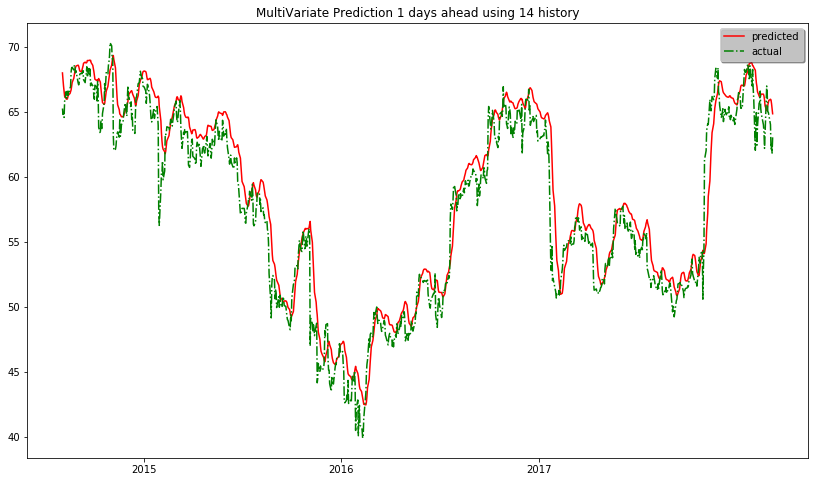

Train (2145, 5) and test (920, 5)
(2145, 5)
X train (2115, 30, 5) and Y train (2115,)
Test dates (890,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 30, 30)            4320      
_________________________________________________________________
lstm_16 (LSTM)               (None, 30)                7320      
_________________________________________________________________
dropout_8 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 31        
Total params: 11,671.0
Trainable params: 11,671.0
Non-trainable params: 0.0
_________________________________________________________________
None
Epoch 1/1
2115/2115 [==============================] - 6s - loss: 0.2333       

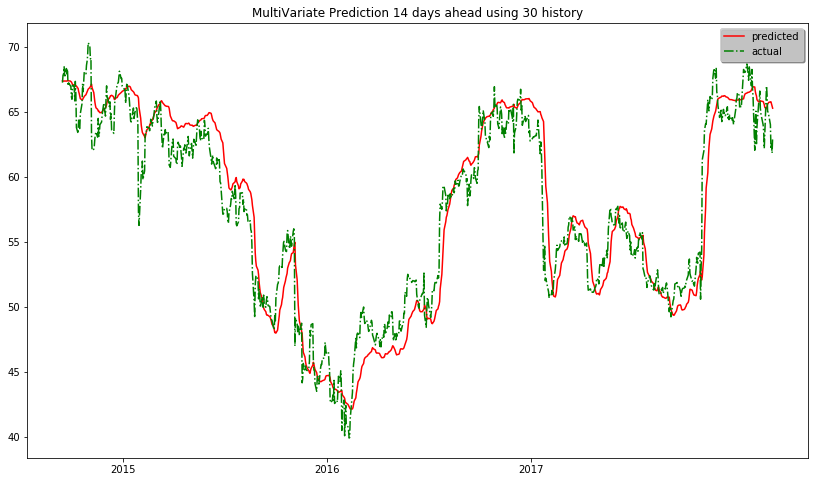

Train (2145, 5) and test (920, 5)
(2145, 5)
X train (2085, 60, 5) and Y train (2085,)
Test dates (860,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (None, 60, 30)            4320      
_________________________________________________________________
lstm_18 (LSTM)               (None, 30)                7320      
_________________________________________________________________
dropout_9 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 31        
Total params: 11,671.0
Trainable params: 11,671.0
Non-trainable params: 0.0
_________________________________________________________________
None
Epoch 1/1
2085/2085 [==============================] - 8s - loss: 0.2166       

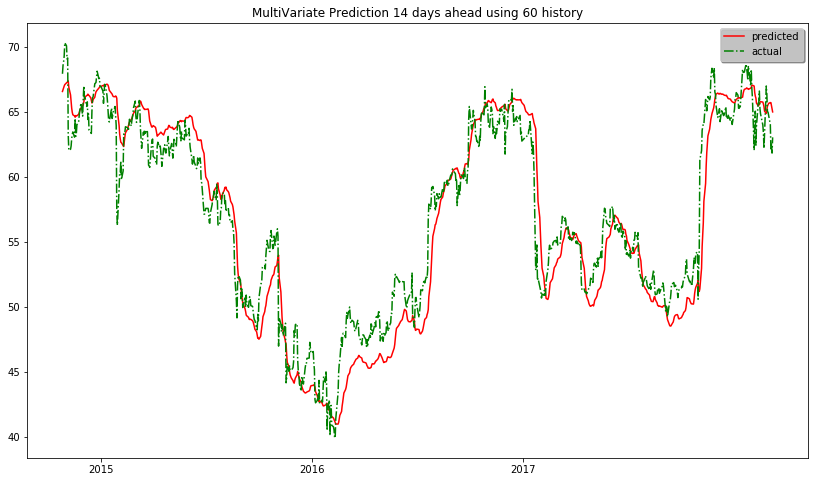

Model3 Scores: 2.0380514252722777 2.2413020772342427 2.3284990602489595


In [17]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import numpy as np
import matplotlib.pyplot as plt
from keras import backend

def predictMultiVariateLSTM(ax, df, m_days, n_days, splits, dates, \
                      neurons=20, num_epochs=1, mBatches=1, mStateFul=False, lossFn='mae', modelOptimizer='sgd'):
    """Do prediction on the LSTM model trained on a multiple varaible
    Evaluate the model using the prediction and plot
    the prediction vs actual values
    """    

    # create the min max scalers for train and test set
    # train and test inputs have multi-variable sequences
    scaler_train = MinMaxScaler(feature_range=(-1, 1))
    testInputScaler = MinMaxScaler(feature_range=(-1, 1))
    # create a special scaler for the single variable prediction
    testPredictionScaler = MinMaxScaler(feature_range=(-1, 1))
    train_test_split = int(df.shape[0] * 0.7)
    df = df.reset_index().drop(['Date'], axis=1)
    train, test = df[0:train_test_split], df[train_test_split:]
    print("Train {} and test {}".format(train.shape, test.shape))
    # scale all the inputs and outputs for training and test
    train_scaled = scaler_train.fit_transform(train[df.columns])
    train_scaled = pd.DataFrame(train_scaled, columns=df.columns)
    test_input_scaled = testInputScaler.fit_transform(test[df.columns])
    test_input_scaled = pd.DataFrame(test_input_scaled, columns=df.columns)
    test_prediction_scaled = testPredictionScaler.fit_transform(test[['Adj. Close']])
    test_prediction_scaled = pd.DataFrame(test_prediction_scaled, columns=['Adj. Close'])

    # prepare data to feed as a LSTM input
    X_train, y_train = prepareMultiVariateLSTMModelData(train_scaled, m_days)
    test_dates = dates[train_test_split+m_days:]

    print("X train {} and Y train {}".format(X_train.shape, y_train.shape))
    print("Test dates {}".format(test_dates.shape))
    model = createLSTMModel(X_train, m_days, n_days, neurons, num_epochs, mBatches, mStateFul, lossFn, modelOptimizer)
    history = None
    for i in range(num_epochs):
        history = model.fit(X_train, y_train,
              epochs=1, batch_size=mBatches)
        model.reset_states()
    # prepare the test input for LSTM prediction
    X_test, y_test = prepareMultiVariateLSTMModelData(test_input_scaled, m_days)
    # predict for n days ahead
    score, y_pred, y_actual = score_prediction(model, testPredictionScaler, X_test, y_test, m_days, n_days)
    # drop dates not applicable to plot
    test_dates = test_dates[n_days:]

    if ax is not None:
        plotTitle = "MultiVariate Prediction {} days ahead using {} history".format(n_days, m_days)
        cs.plot_graph(ax, test_dates, y_pred, y_actual, plotTitle)

    print(score)
    return score

def doMultiVariatePrediction(stock_data, split_count, M_history, N_predict, useStateFul):
    plt.close('all')
    fig, ax = plt.subplots(1, 1, figsize=(14,8))
    stock_frame = stock_data
    stock_dates = stock_frame.index.values
    score = 0
    if (useStateFul == False):
        score = predictMultiVariateLSTM(ax, stock_frame, M_history, N_predict, split_count, stock_dates, 30, 30, 30, False)
    else:
        score = predictMultiVariateLSTM(ax, stock_frame, M_history, N_predict, split_count, stock_dates, 30, 30, 1, True)
    plt.show()
    return score

stockdf = cs.get_stock_dataframe(stock_name, dateFrom = stock_start_date)
print(stockdf.columns)
stockdf = stockdf[['Adj. Close', 'RSI', 'StocOsci', 'ADMI', 'VVR']]
model3_score_14_1 = doMultiVariatePrediction(stockdf, timeSeriesSplitCount, 14, 1, False)
model3_score_30_14 = doMultiVariatePrediction(stockdf, timeSeriesSplitCount, 30, 14, False)
model3_score_60_14 = doMultiVariatePrediction(stockdf, timeSeriesSplitCount, 60, 14, False)
print("Model3 Scores: {} {} {}".format(model3_score_14_1, model3_score_30_14, model3_score_60_14))
# hist, prediction = (14,1), (30,14), (60,14)
# 30 Neuron 10 epoch stateful=False batchSize=30
#Model3 Scores: 3.3747875396646627 2.5487346724593514 3.1695485500409295
# 30 Neuron 10 epoch stateful=True batchSize=1
#Model3 Scores: 11.81975415751083 15.555169356852309 16.410329557547918

#1.7034055157867667 - stateful=False, 14 day history to predict 3 days ahead, 20 neurons, 5 epochs
#1.3275506182291712 - stateful=True, 14 day history to predict 3 days ahead, 30 neurons, 30 epochs
#1.7820831662044965 - stateful=True, 14 day history to predict 3 days ahead, 20 neurons, 5 epochs
#2.7579731522527156 - stateful=True, 60 day history to predict 14 days ahead, 20 neurons, 5 epochs
#4.005008423523437 - stateful=True 30 day history to predict 14 days ahead, 20 neurons, 5 epochs